In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scorecardpy as sc
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### Data Importing

In [2]:
# import the Loan_Defaults, Loan_Attributes and Client_Risk_Quality data
loan_defaults = pd.read_csv("Loan_Defaults.csv")
loan_attributes = pd.read_csv("Loan_Attributes.csv")
client_risk_quality = pd.read_csv("Client_Risk_Quality.csv")

In [3]:
print(loan_defaults.shape)
loan_defaults.head()

(20000, 4)


,UID,RECORDNUMBER,DVAL,DMON
0,2a08b1c1-504b-4178-8c3f-942aa09c7732,8,70.0,6.0
1,039b68a8-0953-484f-a14a-0e1e78ef7794,7,999.0,5.0
2,225b6f92-6c66-45c1-bb82-7ed89aad9619,8,7859.0,27.0
3,d10af710-591d-458e-b81f-85fb99d9c5a8,9,2739.0,9.0
4,6457c750-e7c0-4309-9ca3-8dd2ddbabbc0,8,NaN,NaN


In [4]:
print(loan_attributes.shape)
loan_attributes.head()

(58687, 8)


,UID,RECORDNUMBER,OPENBALANCE,ACCSTARTDATE,FIRST_MONTH,LAST_MONTH,REPAYPERIOD,SEARCHDATE
0,784c964e-d3e1-4dd3-af6c-4288c4b37d27,1,600.0,2014-09-29,2014-10-01,2016-07-01,24.0,20181011
1,fc30d99d-106a-44bf-bc33-9a95f0d2d258,6,500.0,2014-01-24,2014-02-01,2014-07-01,6.0,20180524
2,fc30d99d-106a-44bf-bc33-9a95f0d2d258,9,1149.0,2013-10-18,2013-11-01,2018-05-01,NaN,20180524
3,fc30d99d-106a-44bf-bc33-9a95f0d2d258,14,446.0,2015-07-01,2015-08-01,2015-12-01,5.0,20180524
4,89761744-b42f-43cd-bd3c-5c363c44671a,1,1492.0,2014-10-06,2014-11-01,2015-11-01,13.0,20190924


In [5]:
print(client_risk_quality.shape)
client_risk_quality.head()

(16347, 3)


,UID,SCORE,CLASS
0,440ba427-f46a-41d7-bf6d-5b5b1eb3cc26,524.0,STANDARD
1,8d5f1532-453d-4cce-9ae6-23a06affa479,601.0,STANDARD
2,59ade0ad-460f-49d6-9b3d-359610bee8dd,507.0,STANDARD
3,73252b25-3564-4b73-a27e-a08c2a5e882b,519.0,PREMIUM
4,c85f7e49-61da-42d1-bcf9-ae68c3af7ac8,567.0,PREMIUM


#### Data Preprocessing and Cleaning

In [6]:
# Merge the Loan_Attributes and Client_Risk_Quality using UID
data = pd.merge(loan_attributes, client_risk_quality, on = 'UID', how = 'left')

# As under-sampling is used to balance the data, merge the Loan_Defaults data back to the original Loan_Attributes data for profile exploration
data = pd.merge(data, loan_defaults, on = ['UID', 'RECORDNUMBER'], how = 'left')

# filter out the out-of-scope original loan term samples, keep loans with original term between 1 and 5 years
data = data.loc[(data.REPAYPERIOD >= 12) & (data.REPAYPERIOD <= 60), :]

#### Feature Engineering

In [7]:
# Create default indicator
data['dflag'] = np.where(data.DVAL.notnull() | data.DMON.notnull(), 1, 0)

# Create number of accounts per user
data['num_accounts'] = data.groupby('UID')['RECORDNUMBER'].transform('count')

# Create time span between the last login month and supposed login month based on loan term
data['LAST_MONTH'] = pd.to_datetime(data.LAST_MONTH)
data['ACCSTARTDATE'] = pd.to_datetime(data.ACCSTARTDATE)
data['month_span'] = data['REPAYPERIOD'] - ((data.LAST_MONTH - data.ACCSTARTDATE)/np.timedelta64(1, 'M'))

# Think openbalance, repayperiod, score, class, number of accounts and month_span might be predictive for default behavior

In [8]:
data.head()

,UID,RECORDNUMBER,OPENBALANCE,ACCSTARTDATE,FIRST_MONTH,LAST_MONTH,REPAYPERIOD,SEARCHDATE,SCORE,CLASS,DVAL,DMON,dflag,num_accounts,month_span
0,784c964e-d3e1-4dd3-af6c-4288c4b37d27,1,600.0,2014-09-29,2014-10-01,2016-07-01,24.0,20181011,519.0,PREMIUM,NaN,NaN,0,3,2.940019
4,89761744-b42f-43cd-bd3c-5c363c44671a,1,1492.0,2014-10-06,2014-11-01,2015-11-01,13.0,20190924,516.0,PREMIUM,NaN,NaN,0,2,0.153740
5,89761744-b42f-43cd-bd3c-5c363c44671a,12,59.0,2017-12-01,2018-01-01,2019-09-01,12.0,20190924,516.0,PREMIUM,47.0,13.0,1,2,-8.994271
7,131da6e2-9d4a-4d06-9c81-08875219f7c6,5,2000.0,2016-03-12,2016-04-01,2018-04-01,24.0,20190113,578.0,STANDARD,NaN,NaN,0,2,-0.641163
8,131da6e2-9d4a-4d06-9c81-08875219f7c6,10,166.0,2018-03-14,2018-10-01,2019-01-01,24.0,20190113,578.0,STANDARD,NaN,NaN,0,2,14.373519


In [9]:
data.dtypes

UID                     object
RECORDNUMBER             int64
OPENBALANCE            float64
ACCSTARTDATE    datetime64[ns]
FIRST_MONTH             object
LAST_MONTH      datetime64[ns]
REPAYPERIOD            float64
SEARCHDATE               int64
SCORE                  float64
CLASS                   object
DVAL                   float64
DMON                   float64
dflag                    int32
num_accounts             int64
month_span             float64
dtype: object

In [10]:
data.describe()

,RECORDNUMBER,OPENBALANCE,REPAYPERIOD,SEARCHDATE,SCORE,DVAL,DMON,dflag,num_accounts,month_span
count,35419.000000,34159.000000,35419.000000,3.541900e+04,35419.000000,4221.000000,4221.000000,35419.000000,35419.000000,35412.000000
mean,6.838448,4177.881495,30.316356,2.018563e+07,599.516079,3093.546553,15.623549,0.119173,3.678336,11.345736
std,3.796810,5930.254793,15.682969,6.476318e+03,57.429744,4420.003486,10.352379,0.323997,2.012260,19.399880
min,1.000000,0.000000,12.000000,2.017010e+07,462.000000,3.000000,2.000000,0.000000,1.000000,-244.466211
25%,4.000000,564.000000,20.000000,2.018072e+07,551.000000,412.000000,8.000000,0.000000,2.000000,0.213064
50%,7.000000,1200.000000,24.000000,2.019030e+07,595.000000,1180.000000,13.000000,0.000000,3.000000,8.599355
75%,10.000000,5873.500000,36.000000,2.019071e+07,648.000000,3901.000000,20.000000,0.000000,5.000000,21.373601
max,14.000000,96870.000000,60.000000,2.019093e+07,731.000000,45190.000000,70.000000,1.000000,13.000000,60.755662


In [11]:
data.describe(include = 'object').transpose()

,count,unique,top,freq
UID,35419,13767,5c7ec56d-fd9f-4f4f-ab3d-cd8aa7e1cb44,13
FIRST_MONTH,35419,105,2018-10-01,733
CLASS,35419,2,STANDARD,23311


#### Loss Curve

In [127]:
loan_loss = data.groupby('DMON').agg({'DVAL' : 'sum'}).reset_index()
loan_loss['cum_DVAL'] = loan_loss.DVAL.cumsum()
loan_loss['balance'] = data.OPENBALANCE.sum()
loan_loss['cum_loss'] = loan_loss.cum_DVAL/loan_loss.balance

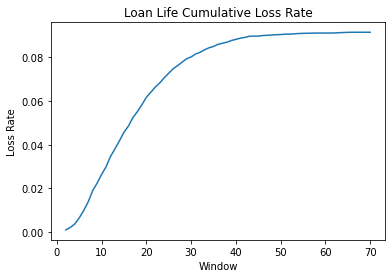

In [133]:
plt.plot(loan_loss.DMON, loan_loss.cum_loss)
plt.ylabel('Loss Rate')
plt.xlabel('Window')
plt.title('Loan Life Cumulative Loss Rate')
plt.show()

#### Balance Paydown Curve

In [223]:
balance_paydown = data.copy()

balance_paydown['payment'] = np.where(balance_paydown.dflag == 1, 
                                      (balance_paydown.OPENBALANCE - balance_paydown.DVAL)/balance_paydown.DMON,
                                       balance_paydown.OPENBALANCE/balance_paydown.REPAYPERIOD)

payment_data = pd.DataFrame(columns=['window', 'payment'])

for i in range(0, 81):
    balance_data = balance_paydown.loc[(balance_paydown.REPAYPERIOD >= i) & ((balance_paydown.DMON >= i) | (balance_paydown.DMON.isnull())), :]
    payment = balance_data.payment.sum()
    
    payment_data.loc[i] = [i, payment]
    
payment_data['cum_payment'] = payment_data.payment.cumsum()
payment_data['balance_pct'] = (data.OPENBALANCE.sum() - payment_data.cum_payment)/data.OPENBALANCE.sum()

payment_data.head()

,window,payment,cum_payment,balance_pct
0,0.0,3.718838e+06,3.718838e+06,0.973942
1,1.0,3.718838e+06,7.437676e+06,0.947883
2,2.0,3.718838e+06,1.115651e+07,0.921825
3,3.0,3.691771e+06,1.484828e+07,0.895956
4,4.0,3.663496e+06,1.851178e+07,0.870286


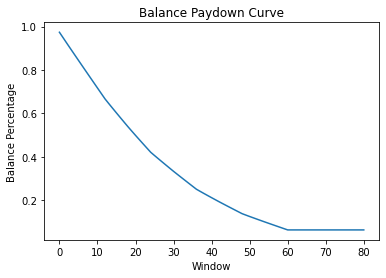

In [224]:
plt.plot(payment_data.window, payment_data.balance_pct)
plt.ylabel('Balance Percentage')
plt.xlabel('Window')
plt.title('Balance Paydown Curve')
plt.show()

In [225]:
# One can also reconstruct the performance data for each loan over dates for detailed over dates analysis, 
# but it takes some time to run.
"""
performance = pd.DataFrame()

for i, j in data.iterrows():
    loan_data = pd.DataFrame()
    loan_data = loan_data.append(j)
    loan_data = loan_data.loc[loan_data.index.repeat(j.REPAYPERIOD)]
    loan_data['payment'] = loan_data['OPENBALANCE']/loan_data['REPAYPERIOD']
    loan_data['balance'] = loan_data.OPENBALANCE - loan_data.payment.cumsum()
    loan_data['month'] = np.arange(loan_data.shape[0])
    loan_data['date'] = loan_data.apply(lambda x: x.ACCSTARTDATE + pd.DateOffset(months = x.month), axis = 1)
    loan_data = loan_data[['UID', 'RECORDNUMBER', 'ACCSTARTDATE', 'DMON', 'DVAL', 'OPENBALANCE', 'dflag', 'date', 'payment', 'balance']]
    
    performance = performance.append(loan_data) 

performance.to_csv('performance.csv')
"""

"\nperformance = pd.DataFrame()\n\nfor i, j in data.iterrows():\n    loan_data = pd.DataFrame()\n    loan_data = loan_data.append(j)\n    loan_data = loan_data.loc[loan_data.index.repeat(j.REPAYPERIOD)]\n    loan_data['payment'] = loan_data['OPENBALANCE']/loan_data['REPAYPERIOD']\n    loan_data['balance'] = loan_data.OPENBALANCE - loan_data.payment.cumsum()\n    loan_data['month'] = np.arange(loan_data.shape[0])\n    loan_data['date'] = loan_data.apply(lambda x: x.ACCSTARTDATE + pd.DateOffset(months = x.month), axis = 1)\n    loan_data = loan_data[['UID', 'RECORDNUMBER', 'ACCSTARTDATE', 'DMON', 'DVAL', 'OPENBALANCE', 'dflag', 'date', 'payment', 'balance']]\n    \n    performance = performance.append(loan_data) \n\nperformance.to_csv('performance.csv')\n"

In [226]:
print(performance.shape)
performance.head(10)

(1073775, 10)


,UID,RECORDNUMBER,ACCSTARTDATE,DMON,DVAL,OPENBALANCE,dflag,date,payment,balance
0,784c964e-d3e1-4dd3-af6c-4288c4b37d27,1.0,2014-09-29,NaN,NaN,600.0,0.0,2014-09-29,25.0,575.0
0,784c964e-d3e1-4dd3-af6c-4288c4b37d27,1.0,2014-09-29,NaN,NaN,600.0,0.0,2014-10-29,25.0,550.0
0,784c964e-d3e1-4dd3-af6c-4288c4b37d27,1.0,2014-09-29,NaN,NaN,600.0,0.0,2014-11-29,25.0,525.0
0,784c964e-d3e1-4dd3-af6c-4288c4b37d27,1.0,2014-09-29,NaN,NaN,600.0,0.0,2014-12-29,25.0,500.0
0,784c964e-d3e1-4dd3-af6c-4288c4b37d27,1.0,2014-09-29,NaN,NaN,600.0,0.0,2015-01-29,25.0,475.0
0,784c964e-d3e1-4dd3-af6c-4288c4b37d27,1.0,2014-09-29,NaN,NaN,600.0,0.0,2015-02-28,25.0,450.0
0,784c964e-d3e1-4dd3-af6c-4288c4b37d27,1.0,2014-09-29,NaN,NaN,600.0,0.0,2015-03-29,25.0,425.0
0,784c964e-d3e1-4dd3-af6c-4288c4b37d27,1.0,2014-09-29,NaN,NaN,600.0,0.0,2015-04-29,25.0,400.0
0,784c964e-d3e1-4dd3-af6c-4288c4b37d27,1.0,2014-09-29,NaN,NaN,600.0,0.0,2015-05-29,25.0,375.0
0,784c964e-d3e1-4dd3-af6c-4288c4b37d27,1.0,2014-09-29,NaN,NaN,600.0,0.0,2015-06-29,25.0,350.0


#### Customer Risk Profile

In [232]:
customer_data = data.groupby('UID').agg({'RECORDNUMBER' : 'count', 
                                         'OPENBALANCE' : 'sum', 
                                         'ACCSTARTDATE' : 'first', 
                                         'LAST_MONTH' : 'last', 
                                         'REPAYPERIOD' : 'mean', 
                                         'SCORE' : 'mean', 
                                         'CLASS' : 'first'}).reset_index()

In [234]:
customer_data.describe()

,RECORDNUMBER,OPENBALANCE,REPAYPERIOD,SCORE
count,13767.000000,13767.000000,13767.000000,13767.000000
mean,2.572746,10366.256556,30.204021,594.822111
std,1.686597,14401.025861,13.635143,58.513170
min,1.000000,0.000000,12.000000,462.000000
25%,1.000000,1200.000000,21.000000,545.000000
50%,2.000000,4788.000000,25.200000,586.000000
75%,3.000000,14217.000000,37.450000,645.000000
max,13.000000,192497.000000,60.000000,731.000000


In [237]:
customer_data.describe(include = 'object').transpose()

,count,unique,top,freq
UID,13767,13767,272865d2-7869-445e-a772-91f5e76d0e99,1
CLASS,13767,2,STANDARD,9151


#### Exploratory Analysis

In [243]:
# information value to see predictive power
# as shown below, score, month_span, openbalance, num_accounts, repayperiod are quite predictive
sc.iv(data, 'dflag')

,variable,info_value
7,DMON,15.380886
8,DVAL,10.579244
13,SCORE,1.813817
3,month_span,1.238260
9,OPENBALANCE,1.154598
12,LAST_MONTH,0.837700
11,num_accounts,0.652928
1,ACCSTARTDATE,0.639950
10,UID,0.521418
2,SEARCHDATE,0.328711


In [244]:
sc.iv(data[['SCORE', 'month_span', 'OPENBALANCE', 'num_accounts', 'REPAYPERIOD', 'CLASS', 'dflag']], 'dflag')

,variable,info_value
5,SCORE,1.813817
0,month_span,1.238260
3,OPENBALANCE,1.154598
4,num_accounts,0.652928
1,REPAYPERIOD,0.222087
2,CLASS,0.002989


[INFO] creating woe binning ...


{'SCORE': <Figure size 432x288 with 2 Axes>,
 'month_span': <Figure size 432x288 with 2 Axes>,
 'OPENBALANCE': <Figure size 432x288 with 2 Axes>,
 'num_accounts': <Figure size 432x288 with 2 Axes>,
 'REPAYPERIOD': <Figure size 432x288 with 2 Axes>,
 'CLASS': <Figure size 432x288 with 2 Axes>}

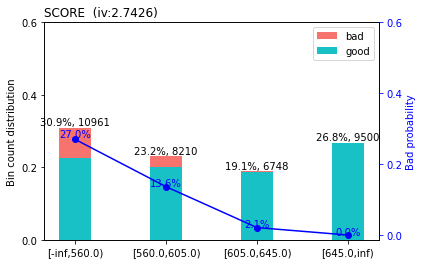

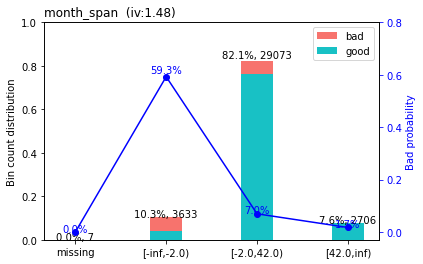

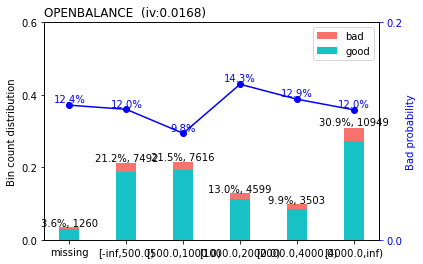

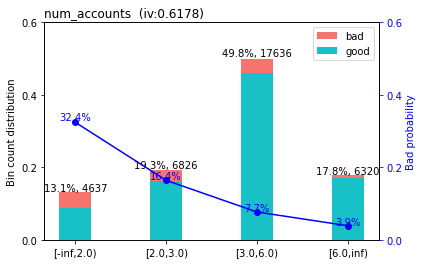

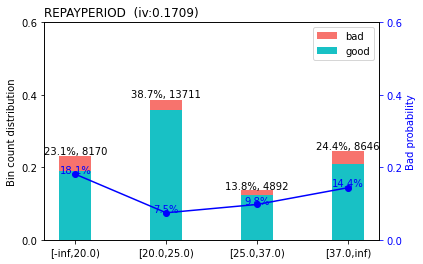

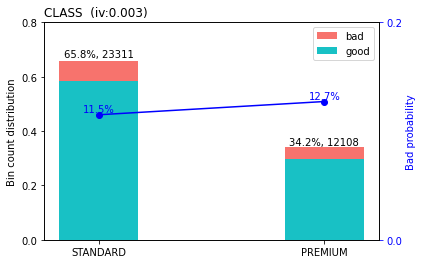

In [246]:
# The higher the score, the lower the PD
# The higher the previous payment, the lower the PD.
# The higher number of accounts, the lower the PD.
# The relationship of month_span is nonlinear.
bins = sc.woebin(data, 'dflag', ['SCORE', 'month_span', 'OPENBALANCE', 'num_accounts', 'REPAYPERIOD', 'CLASS'])

sc.woebin_plot(bins)

In [437]:
# VIF test, high VIF for some attributes
vif_data = data[['SCORE', 'month_span', 'OPENBALANCE', 'num_accounts', 'REPAYPERIOD', 'dflag']].copy()
vif_data = vif_data.dropna()

x_0 = model_data.iloc[:, :-1]
vif = pd.DataFrame()
vif['feature'] = x_0.columns
vif['VIF'] = [variance_inflation_factor(x_0.values, i) for i in range(len(x_0.columns))]
vif

,feature,VIF
0,SCORE,9.802786
1,month_span,2.095765
2,OPENBALANCE,2.499710
3,num_accounts,4.485332
4,REPAYPERIOD,10.373762


#### A common method for score card is to bucket/binning the variables, but for this practice, continuous variable will be used.

#### Preprocessing

In [12]:
model_data = data[['SCORE', 'month_span', 'OPENBALANCE', 'num_accounts', 'REPAYPERIOD', 'CLASS', 'dflag']].dropna()

x = model_data[['SCORE', 'month_span', 'OPENBALANCE', 'num_accounts', 'REPAYPERIOD', 'CLASS']]

y = model_data['dflag']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=1)

In [13]:
# Convert to categorical variable
x_train = x_train.copy()
x_test = x_test.copy()

encoder = OneHotEncoder(drop = 'first')
encoder.fit_transform(x_train[['CLASS']])

x_train[encoder.get_feature_names(['CLASS'])] = OneHotEncoder(drop = 'first').fit_transform(x_train[['CLASS']]).toarray()
x_test[encoder.get_feature_names(['CLASS'])] = encoder.transform(x_test[['CLASS']]).toarray()


In [14]:
# save the original copy of the data for tree-based models or non-normalized models
x_ori_train = x_train.copy()
x_ori_test = x_test.copy()

In [15]:
# Standardization for logistic regression
num_features = x_train.columns.drop(['CLASS', 'CLASS_STANDARD'])

normalizer = StandardScaler()
x_train[num_features] = normalizer.fit_transform(x_train[num_features])
x_test[num_features] = normalizer.transform(x_test[num_features])


In [16]:
x_train

,SCORE,month_span,OPENBALANCE,num_accounts,REPAYPERIOD,CLASS,CLASS_STANDARD
37645,-0.162183,-0.751252,0.283248,0.152978,-0.438520,PREMIUM,0.0
19916,-0.197173,-0.655381,-0.584232,0.152978,-0.438520,STANDARD,1.0
22322,-0.284647,1.387072,0.981001,0.649164,1.864677,STANDARD,1.0
53567,0.642583,2.058170,1.571769,1.145349,1.864677,STANDARD,1.0
16141,-0.861980,-0.503730,0.412269,-0.343208,-0.438520,PREMIUM,0.0
...,...,...,...,...,...,...,...
13705,1.149936,-0.217860,-0.251168,-0.343208,-0.438520,STANDARD,1.0
55794,-0.319637,0.420120,-0.535787,-0.343208,-0.438520,STANDARD,1.0
9066,0.607594,-0.253144,-0.551430,2.137721,-1.206253,STANDARD,1.0
21188,-1.176888,-0.338134,-0.464295,-0.839393,-0.438520,PREMIUM,0.0


In [17]:
x_test

,SCORE,month_span,OPENBALANCE,num_accounts,REPAYPERIOD,CLASS,CLASS_STANDARD
19492,-1.229373,-0.636206,-0.584232,3.130092,-0.438520,PREMIUM,0.0
39075,-1.421817,1.025402,-0.158650,1.145349,0.329212,PREMIUM,0.0
44397,-1.439312,-0.794830,0.135725,0.649164,-0.438520,PREMIUM,0.0
32194,0.625089,-0.274062,-0.579186,0.649164,-1.206253,STANDARD,1.0
23130,1.482340,-0.772169,-0.495247,0.152978,-0.438520,STANDARD,1.0
...,...,...,...,...,...,...,...
44147,-0.022223,0.413587,-0.515433,0.152978,-0.694431,STANDARD,1.0
4241,1.552319,2.333582,-0.200704,0.649164,1.864677,STANDARD,1.0
51431,0.205210,0.282414,0.645077,2.633906,-0.438520,PREMIUM,0.0
33197,-0.442102,-0.165566,-0.624604,1.145349,-0.438520,PREMIUM,0.0


#### As the data is unbalanced, the following models will focus on F1 score metrics, model will also be trained on the balanced dataset provided before using undersampling method.

#### Feature Selection

In [18]:
x_fs = x_train.drop(['CLASS'], axis = 1)
y_fs = y_train

In [19]:
# forward selection, parsimonious.
ffs = SFS(LogisticRegression(C = 1e9, fit_intercept = False), 
          k_features = 'parsimonious',
          forward = True,
          scoring = 'f1',
          cv = 5).fit(sm.add_constant(x_fs), y_fs)

print(ffs.k_feature_names_)
print(ffs.k_score_)

('const', 'SCORE', 'month_span', 'OPENBALANCE', 'num_accounts', 'REPAYPERIOD', 'CLASS_STANDARD')
0.5400692897178095


In [20]:
# backward selection, parsimonious.
sbs = SFS(LogisticRegression(C = 1e9, fit_intercept = False), 
          k_features = 'parsimonious',
          forward = False,
          scoring = 'f1',
          cv = 5).fit(sm.add_constant(x_fs), y_fs)

print(sbs.k_feature_names_)
print(sbs.k_score_)

('const', 'SCORE', 'month_span', 'OPENBALANCE', 'num_accounts', 'REPAYPERIOD', 'CLASS_STANDARD')
0.5400692897178095


In [21]:
# stepwise feature selection, parsimounious.
sffs = SFS(LogisticRegression(C = 1e9, fit_intercept = False), 
          k_features = 'parsimonious',
          forward = True,
          floating = True,
          scoring = 'f1',
          cv = 5).fit(sm.add_constant(x_fs), y_fs)

print(sffs.k_feature_names_)
print(sffs.k_score_)

('const', 'SCORE', 'month_span', 'OPENBALANCE', 'num_accounts', 'REPAYPERIOD', 'CLASS_STANDARD')
0.5400692897178095


#### As the data is unbalanced, the following models will focus on F1 score metrics, model will also be trained on the balanced dataset provided before using undersampling method.  KFold cross validation is used for validation.

#### Logistic Regression Modeling

In [22]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 1)

In [23]:
model_1 = smf.logit(formula = 'dflag ~ SCORE + month_span + OPENBALANCE + num_accounts + REPAYPERIOD + CLASS', data = pd.concat([x_train, y_train], axis = 1)).fit()

Optimization terminated successfully.
         Current function value: 0.210920
         Iterations 8


In [24]:
print(model_1.summary())

                           Logit Regression Results                           
Dep. Variable:                  dflag   No. Observations:                30742
Model:                          Logit   Df Residuals:                    30735
Method:                           MLE   Df Model:                            6
Date:                Fri, 30 Jul 2021   Pseudo R-squ.:                  0.4226
Time:                        15:28:00   Log-Likelihood:                -6484.1
converged:                       True   LL-Null:                       -11230.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.4923      0.054    -64.399      0.000      -3.599      -3.386
CLASS[T.STANDARD]    -0.1061      0.048     -2.233      0.026      -0.199      -0.013
SCORE                -1.

In [25]:
x_cv = x_train.drop(['CLASS'], axis = 1)
y_cv = y_train

model_1_cv = LogisticRegression(C = 1e9, fit_intercept = False)

scores_1 = cross_val_score(model_1_cv, sm.add_constant(x_cv), y_cv, scoring = 'f1', cv = folds)

scores_1

array([0.51928021, 0.51802179, 0.5508982 , 0.55849701, 0.55390009])

In [26]:
# VIF test, low VIF
x_1 = x_train.drop(['CLASS'], axis = 1)
vif = pd.DataFrame()
vif['feature'] = x_1.columns
vif['VIF'] = [variance_inflation_factor(x_1.values, i) for i in range(len(x_1.columns))]
vif

,feature,VIF
0,SCORE,1.073914
1,month_span,1.507875
2,OPENBALANCE,1.736282
3,num_accounts,1.039636
4,REPAYPERIOD,2.154854
5,CLASS_STANDARD,1.002403


#### Logistic Regression Modeling using variables without normalization for easier interpretation

In [27]:
model_2 = smf.logit(formula = 'dflag ~ SCORE + month_span + OPENBALANCE + num_accounts + REPAYPERIOD + CLASS', data = pd.concat([x_ori_train, y_train], axis = 1)).fit()

Optimization terminated successfully.
         Current function value: 0.210920
         Iterations 9


In [28]:
print(model_2.summary())

                           Logit Regression Results                           
Dep. Variable:                  dflag   No. Observations:                30742
Model:                          Logit   Df Residuals:                    30735
Method:                           MLE   Df Model:                            6
Date:                Fri, 30 Jul 2021   Pseudo R-squ.:                  0.4226
Time:                        15:28:05   Log-Likelihood:                -6484.1
converged:                       True   LL-Null:                       -11230.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            17.1477      0.379     45.237      0.000      16.405      17.891
CLASS[T.STANDARD]    -0.1061      0.048     -2.233      0.026      -0.199      -0.013
SCORE                -0.

In [99]:
x_cv = x_ori_train.drop(['CLASS'], axis = 1)
y_cv = y_train

model_2_cv = LogisticRegression(C = 1e9, fit_intercept = False, max_iter = 500)

scores_2 = cross_val_score(model_2_cv, sm.add_constant(x_cv), y_cv, scoring = 'f1', cv = folds)

scores_2

array([0.51928021, 0.51802179, 0.38445808, 0.55849701, 0.37579618])

In [30]:
# VIF test, some high VIF, might need to drop some variables
x_2 = x_ori_train.drop(['CLASS'], axis = 1)
vif = pd.DataFrame()
vif['feature'] = x_2.columns
vif['VIF'] = [variance_inflation_factor(x_2.values, i) for i in range(len(x_2.columns))]
vif

,feature,VIF
0,SCORE,11.722188
1,month_span,2.095310
2,OPENBALANCE,2.517950
3,num_accounts,4.486043
4,REPAYPERIOD,10.354730
5,CLASS_STANDARD,2.920971


#### Logistic Regression Modeling tuning Hyperparameters

In [31]:
x_ht = x_train.drop(['CLASS'], axis = 1)
y_ht = y_train

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver = solvers, penalty = penalty, C = c_values)
grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = folds, scoring='f1', error_score=0)
grid_result = grid_search.fit(x_ht, y_ht)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.540311 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.540119 (0.017700) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.540119 (0.017700) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.540119 (0.017700) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.540215 (0.017800) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.540215 (0.017800) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.540215 (0.017800) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.540311 (0.017901) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.540311 (0.017901) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.540215 (0.017800) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.536126 (0.017864) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.536126 (0.017864) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.537174 (0.018599) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.513399 (0.021458) wit

In [32]:
model_3 = LogisticRegression(solver = 'newton-cg', penalty = 'l2', C = 1).fit(x_ht, y_ht)

scores_3 = cross_val_score(model_3, x_ht, y_ht, scoring = 'f1', cv = folds)

scores_3

array([0.51928021, 0.51802179, 0.5508982 , 0.55945252, 0.55390009])

#### Decision Tree Modeling

In [33]:
x_tree = x_ori_train.drop(['CLASS'], axis = 1)
y_tree = y_train

# define models and parameters
model = tree.DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

# define grid search
grid = dict(criterion = criterion, max_depth = max_depth)
grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = folds, scoring='f1', error_score=0)
grid_result = grid_search.fit(x_tree, y_tree)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.635803 using {'criterion': 'gini', 'max_depth': 8}
0.588777 (0.008400) with: {'criterion': 'gini', 'max_depth': 2}
0.599455 (0.034314) with: {'criterion': 'gini', 'max_depth': 4}
0.634102 (0.019711) with: {'criterion': 'gini', 'max_depth': 6}
0.635803 (0.013635) with: {'criterion': 'gini', 'max_depth': 8}
0.625689 (0.011276) with: {'criterion': 'gini', 'max_depth': 10}
0.619293 (0.013010) with: {'criterion': 'gini', 'max_depth': 12}
0.588061 (0.007772) with: {'criterion': 'entropy', 'max_depth': 2}
0.581464 (0.024221) with: {'criterion': 'entropy', 'max_depth': 4}
0.616489 (0.008530) with: {'criterion': 'entropy', 'max_depth': 6}
0.635079 (0.007180) with: {'criterion': 'entropy', 'max_depth': 8}
0.627681 (0.016502) with: {'criterion': 'entropy', 'max_depth': 10}
0.623683 (0.010754) with: {'criterion': 'entropy', 'max_depth': 12}


In [34]:
model_4 = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 8).fit(x_tree, y_tree)

scores_4 = cross_val_score(model_4, x_tree, y_tree, scoring = 'f1', cv = folds)

scores_4

array([0.61838006, 0.62202381, 0.65625   , 0.63609023, 0.64551943])

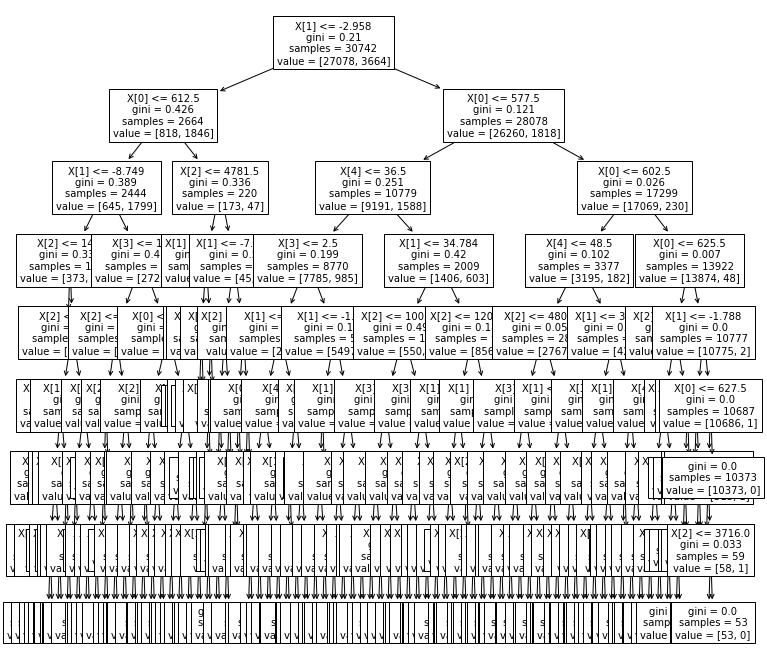

In [35]:
plt.figure(figsize = (12, 12))
tree.plot_tree(model_4, fontsize = 10)
plt.show()

In [36]:
tree.export_text(model_4)

'|--- feature_1 <= -2.96\n|   |--- feature_0 <= 612.50\n|   |   |--- feature_1 <= -8.75\n|   |   |   |--- feature_2 <= 14.50\n|   |   |   |   |--- class: 0\n|   |   |   |--- feature_2 >  14.50\n|   |   |   |   |--- feature_2 <= 80.00\n|   |   |   |   |   |--- feature_1 <= -9.01\n|   |   |   |   |   |   |--- feature_4 <= 20.00\n|   |   |   |   |   |   |   |--- feature_3 <= 3.50\n|   |   |   |   |   |   |   |   |--- class: 1\n|   |   |   |   |   |   |   |--- feature_3 >  3.50\n|   |   |   |   |   |   |   |   |--- class: 1\n|   |   |   |   |   |   |--- feature_4 >  20.00\n|   |   |   |   |   |   |   |--- feature_1 <= -30.70\n|   |   |   |   |   |   |   |   |--- class: 0\n|   |   |   |   |   |   |   |--- feature_1 >  -30.70\n|   |   |   |   |   |   |   |   |--- class: 1\n|   |   |   |   |   |--- feature_1 >  -9.01\n|   |   |   |   |   |   |--- feature_2 <= 56.50\n|   |   |   |   |   |   |   |--- class: 0\n|   |   |   |   |   |   |--- feature_2 >  56.50\n|   |   |   |   |   |   |   |--- fea

Text(0, 0.5, 'Feature Importance Score')

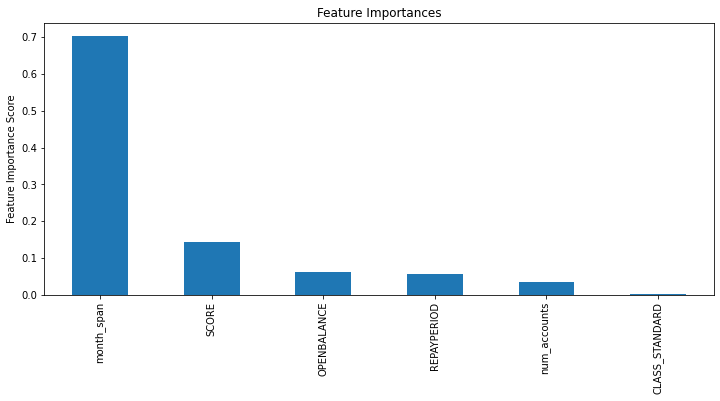

In [37]:
plt.figure(figsize = (12, 5))
feat_imp = pd.Series(model_4.feature_importances_, x_tree.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title = 'Feature Importances')
plt.ylabel('Feature Importance Score')

#### Gradient Boosting

In [38]:
# define models and parameters
model = GradientBoostingClassifier()
n_estimators = [10, 100, 250]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]

# define grid search
grid = dict(learning_rate = learning_rate, n_estimators = n_estimators, subsample = subsample, max_depth = max_depth)

grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = folds, scoring = 'f1', error_score = 0)
grid_result = grid_search.fit(x_tree, y_tree)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.663921 using {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.5}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.7}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_

In [39]:
model_5 = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, 
                                     subsample = 1.0, max_depth = 7).fit(x_tree, y_tree)

scores_5 = cross_val_score(model_5, x_tree, y_tree, scoring = 'f1', cv = folds)

scores_5

array([0.66221232, 0.64590876, 0.65914221, 0.67112101, 0.6870229 ])

Text(0, 0.5, 'Feature Importance Score')

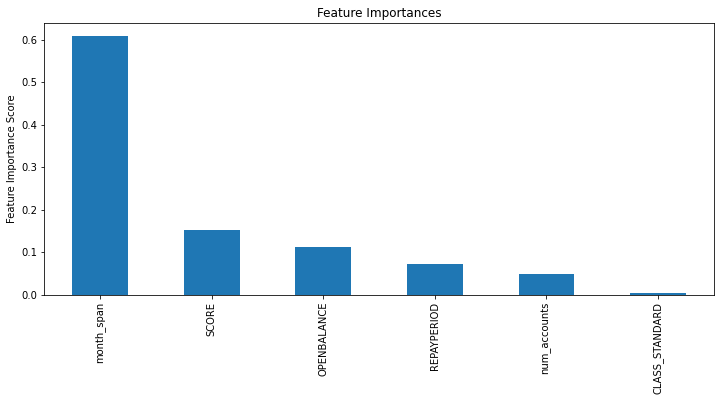

In [40]:
plt.figure(figsize = (12, 5))
feat_imp = pd.Series(model_5.feature_importances_, x_tree.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### Logistic Regression on More Balanced Data

In [438]:
# Merge back to find the balanced data in the training dataset
balanced_data = pd.merge(loan_defaults[['UID', 'RECORDNUMBER']], data.loc[x_train.index, :], on = ['UID', 'RECORDNUMBER'], how = 'inner')

In [439]:
balanced_data.dflag.mean()

0.3538728993625652

In [440]:
x_bd = balanced_data[['SCORE', 'month_span', 'OPENBALANCE', 'num_accounts', 'REPAYPERIOD', 'CLASS']].copy()

y_bd = balanced_data['dflag']

x_bd[encoder.get_feature_names(['CLASS'])] = encoder.transform(x_bd[['CLASS']]).toarray()

In [441]:
normalizer_bd = StandardScaler()

x_bd_train = x_bd.copy()
x_bd_test = x_ori_test.copy()

x_bd_train[num_features] = normalizer_bd.fit_transform(x_bd_train[num_features])
x_bd_test[num_features] = normalizer_bd.transform(x_bd_test[num_features])

In [442]:
model_6 = smf.logit(formula = 'dflag ~ SCORE + month_span + OPENBALANCE + num_accounts + REPAYPERIOD + CLASS', data = pd.concat([x_bd_train, y_bd], axis = 1)).fit()

Optimization terminated successfully.
         Current function value: 0.248150
         Iterations 8


In [443]:
print(model_6.summary())

                           Logit Regression Results                           
Dep. Variable:                  dflag   No. Observations:                10354
Model:                          Logit   Df Residuals:                    10347
Method:                           MLE   Df Model:                            6
Date:                Fri, 30 Jul 2021   Pseudo R-squ.:                  0.6181
Time:                        22:17:33   Log-Likelihood:                -2569.3
converged:                       True   LL-Null:                       -6728.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.6507      0.072    -22.992      0.000      -1.791      -1.510
CLASS[T.STANDARD]    -0.2139      0.075     -2.869      0.004      -0.360      -0.068
SCORE                -3.

In [445]:
x_cv = x_bd_train.drop(['CLASS'], axis = 1)
y_cv = y_bd

model_6_cv = LogisticRegression(C = 1e9, fit_intercept = False, max_iter = 500)

scores_6 = cross_val_score(model_6_cv, sm.add_constant(x_cv), y_cv, scoring = 'f1', cv = folds)

scores_6

array([0.84133333, 0.85080645, 0.84413793, 0.84168337, 0.8533704 ])

#### Gradient Bossting on More Balanced Data

In [451]:
x_tree_bd = x_bd.drop(['CLASS'], axis = 1)

# define models and parameters
model = GradientBoostingClassifier()
n_estimators = [10, 100, 250]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]

# define grid search
grid = dict(learning_rate = learning_rate, n_estimators = n_estimators, subsample = subsample, max_depth = max_depth)

grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = folds, scoring = 'f1', error_score = 0)
grid_result = grid_search.fit(x_tree_bd, y_bd)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.880740 using {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 250, 'subsample': 0.5}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.5}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.7}
0.000000 (0.000000) with: {'learning_rate': 0.001, 'max

In [452]:
model_7 = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 250, 
                                     subsample = 0.5, max_depth = 7).fit(x_tree_bd, y_bd)

scores_7 = cross_val_score(model_7, x_tree_bd, y_bd, scoring = 'f1', cv = folds)

scores_7

array([0.86693548, 0.87407407, 0.88231246, 0.87417219, 0.89437586])

Text(0, 0.5, 'Feature Importance Score')

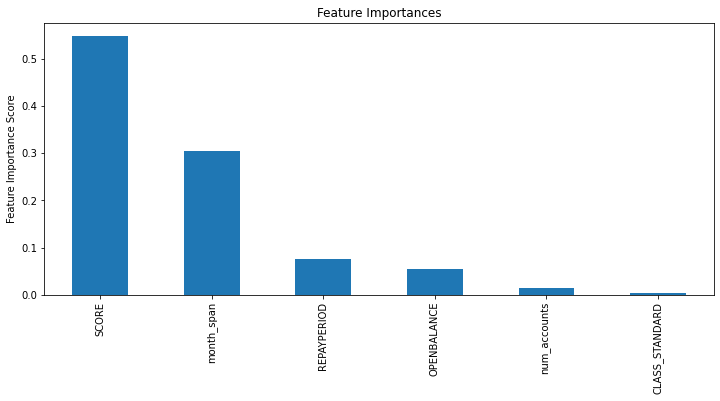

In [453]:
plt.figure(figsize = (12, 5))
feat_imp = pd.Series(model_7.feature_importances_, x_tree_bd.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### Metrics on Training and Validation Data

In [454]:
model_1.predict()

array([0.08360958, 0.04952387, 0.02741986, ..., 0.00096935, 0.32469619,
       0.02143927])

In [455]:
model_2.predict()

array([0.08360958, 0.04952387, 0.02741986, ..., 0.00096935, 0.32469619,
       0.02143927])

In [456]:
model_3.predict_proba(x_ht)

array([[9.16212092e-01, 8.37879084e-02],
       [9.50319773e-01, 4.96802271e-02],
       [9.72511542e-01, 2.74884581e-02],
       ...,
       [9.99021191e-01, 9.78808578e-04],
       [6.75457191e-01, 3.24542809e-01],
       [9.78500289e-01, 2.14997108e-02]])

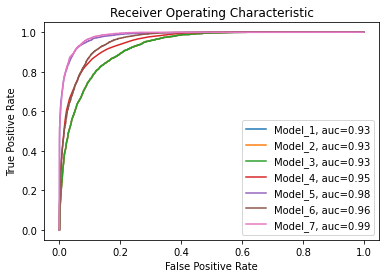

In [458]:
y_pred_proba_1 = model_1.predict()
fpr_1, tpr_1, _ = metrics.roc_curve(y_train, y_pred_proba_1)
auc_1 = round(metrics.roc_auc_score(y_train, y_pred_proba_1), 2)

y_pred_proba_2 = model_2.predict()
fpr_2, tpr_2, _ = metrics.roc_curve(y_train, y_pred_proba_2)
auc_2 = round(metrics.roc_auc_score(y_train, y_pred_proba_2), 2)

y_pred_proba_3 = model_3.predict_proba(x_ht)[::, 1]
fpr_3, tpr_3, _ = metrics.roc_curve(y_train, y_pred_proba_3)
auc_3 = round(metrics.roc_auc_score(y_train, y_pred_proba_3), 2)

y_pred_proba_4 = model_4.predict_proba(x_tree)[::, 1]
fpr_4, tpr_4, _ = metrics.roc_curve(y_tree, y_pred_proba_4)
auc_4 = round(metrics.roc_auc_score(y_tree, y_pred_proba_4), 2)

y_pred_proba_5 = model_5.predict_proba(x_tree)[::, 1]
fpr_5, tpr_5, _ = metrics.roc_curve(y_tree, y_pred_proba_5)
auc_5 = round(metrics.roc_auc_score(y_tree, y_pred_proba_5), 2)

y_pred_proba_6 = model_6.predict()
fpr_6, tpr_6, _ = metrics.roc_curve(y_bd, y_pred_proba_6)
auc_6 = round(metrics.roc_auc_score(y_bd, y_pred_proba_6), 2)

y_pred_proba_7 = model_7.predict_proba(x_tree_bd)[::, 1]
fpr_7, tpr_7, _ = metrics.roc_curve(y_bd, y_pred_proba_7)
auc_7 = round(metrics.roc_auc_score(y_bd, y_pred_proba_7), 2)

plt.plot(fpr_1, tpr_1, label = "Model_1, auc="+str(auc_1))
plt.plot(fpr_2, tpr_2, label = "Model_2, auc="+str(auc_2))
plt.plot(fpr_3, tpr_3, label = "Model_3, auc="+str(auc_3))
plt.plot(fpr_4, tpr_4, label = "Model_4, auc="+str(auc_4))
plt.plot(fpr_5, tpr_5, label = "Model_5, auc="+str(auc_5))
plt.plot(fpr_6, tpr_6, label = "Model_6, auc="+str(auc_6))
plt.plot(fpr_7, tpr_7, label = "Model_7, auc="+str(auc_7))

plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 4)
plt.show()

In [461]:
models = ['model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7']

cvf1 = [round(scores_1.mean(), 2), round(scores_2.mean(), 2), 
        round(scores_3.mean(), 2), round(scores_4.mean(), 2), 
        round(scores_5.mean(), 2), round(scores_6.mean(), 2),
        round(scores_7.mean(), 2)]

accuracy = [round(metrics.accuracy_score(y_train, list(map(round, model_1.predict()))), 2), 
            round(metrics.accuracy_score(y_train, list(map(round, model_2.predict()))), 2), 
            round(model_3.score(x_ht, y_train), 2), 
            round(model_4.score(x_tree, y_tree), 2), 
            round(model_5.score(x_tree, y_tree), 2), 
            round(metrics.accuracy_score(y_bd, list(map(round, model_6.predict()))), 2),
            round(model_7.score(x_tree_bd, y_bd), 2),]

auc = [auc_1, auc_2, auc_3, auc_4, auc_5, auc_6, auc_7]

dict_metrics = {'models' : models, 'cross validation f1 score' : cvf1, 
                'accuracy' : accuracy, 'auc' : auc}

pd.DataFrame(dict_metrics)

,models,cross validation f1 score,accuracy,auc
0,model_1,0.54,0.91,0.93
1,model_2,0.47,0.91,0.93
2,model_3,0.54,0.91,0.93
3,model_4,0.64,0.93,0.95
4,model_5,0.67,0.96,0.98
5,model_6,0.85,0.89,0.96
6,model_7,0.88,0.93,0.99


#### Metrics on Test Data

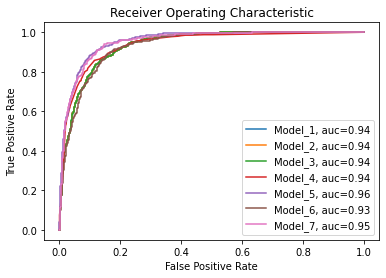

In [466]:
y_pred_proba_1 = model_1.predict(x_test)
fpr_1, tpr_1, _ = metrics.roc_curve(y_test, y_pred_proba_1)
auc_1 = round(metrics.roc_auc_score(y_test, y_pred_proba_1), 2)

y_pred_proba_2 = model_2.predict(x_ori_test)
fpr_2, tpr_2, _ = metrics.roc_curve(y_test, y_pred_proba_2)
auc_2 = round(metrics.roc_auc_score(y_test, y_pred_proba_2), 2)

y_pred_proba_3 = model_3.predict_proba(x_test.drop(['CLASS'], axis = 1))[::, 1]
fpr_3, tpr_3, _ = metrics.roc_curve(y_test, y_pred_proba_3)
auc_3 = round(metrics.roc_auc_score(y_test, y_pred_proba_3), 2)

y_pred_proba_4 = model_4.predict_proba(x_ori_test.drop(['CLASS'], axis = 1))[::, 1]
fpr_4, tpr_4, _ = metrics.roc_curve(y_test, y_pred_proba_4)
auc_4 = round(metrics.roc_auc_score(y_test, y_pred_proba_4), 2)

y_pred_proba_5 = model_5.predict_proba(x_ori_test.drop(['CLASS'], axis = 1))[::, 1]
fpr_5, tpr_5, _ = metrics.roc_curve(y_test, y_pred_proba_5)
auc_5 = round(metrics.roc_auc_score(y_test, y_pred_proba_5), 2)

y_pred_proba_6 = model_6.predict(x_bd_test)
fpr_6, tpr_6, _ = metrics.roc_curve(y_test, y_pred_proba_6)
auc_6 = round(metrics.roc_auc_score(y_test, y_pred_proba_6), 2)

y_pred_proba_7 = model_7.predict_proba(x_ori_test.drop(['CLASS'], axis = 1))[::, 1]
fpr_7, tpr_7, _ = metrics.roc_curve(y_test, y_pred_proba_7)
auc_7 = round(metrics.roc_auc_score(y_test, y_pred_proba_7), 2)

plt.plot(fpr_1, tpr_1, label = "Model_1, auc="+str(auc_1))
plt.plot(fpr_2, tpr_2, label = "Model_2, auc="+str(auc_2))
plt.plot(fpr_3, tpr_3, label = "Model_3, auc="+str(auc_3))
plt.plot(fpr_4, tpr_4, label = "Model_4, auc="+str(auc_4))
plt.plot(fpr_5, tpr_5, label = "Model_5, auc="+str(auc_5))
plt.plot(fpr_6, tpr_6, label = "Model_6, auc="+str(auc_6))
plt.plot(fpr_7, tpr_7, label = "Model_7, auc="+str(auc_7))

plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 4)
plt.show()

In [468]:
models = ['model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7']

f1 = [round(f1_score(y_test, list(map(round, model_1.predict(x_test)))), 2), 
      round(f1_score(y_test, list(map(round, model_2.predict(x_ori_test)))), 2), 
      round(f1_score(y_test, model_3.predict(x_test.drop(['CLASS'], axis = 1))), 2), 
      round(f1_score(y_test, model_4.predict(x_ori_test.drop(['CLASS'], axis = 1))), 2), 
      round(f1_score(y_test, model_5.predict(x_ori_test.drop(['CLASS'], axis = 1))), 2), 
      round(f1_score(y_test, list(map(round, model_6.predict(x_bd_test)))), 2),
      round(f1_score(y_test, model_7.predict(x_ori_test.drop(['CLASS'], axis = 1))), 2)]

accuracy = [round(metrics.accuracy_score(y_test, list(map(round, model_1.predict(x_test)))), 2), 
            round(metrics.accuracy_score(y_test, list(map(round, model_2.predict(x_ori_test)))), 2), 
            round(model_3.score(x_test.drop(['CLASS'], axis = 1), y_test), 2), 
            round(model_4.score(x_ori_test.drop(['CLASS'], axis = 1), y_test), 2), 
            round(model_5.score(x_ori_test.drop(['CLASS'], axis = 1), y_test), 2), 
            round(metrics.accuracy_score(y_test, list(map(round, model_6.predict(x_bd_test)))), 2),
            round(model_7.score(x_ori_test.drop(['CLASS'], axis = 1), y_test), 2),]

auc = [auc_1, auc_2, auc_3, auc_4, auc_5, auc_6, auc_7]

dict_metrics = {'models' : models, 'f1 score' : f1, 
                'accuracy' : accuracy, 'auc' : auc}

pd.DataFrame(dict_metrics)

,models,f1 score,accuracy,auc
0,model_1,0.53,0.91,0.94
1,model_2,0.53,0.91,0.94
2,model_3,0.53,0.91,0.94
3,model_4,0.65,0.93,0.94
4,model_5,0.66,0.93,0.96
5,model_6,0.58,0.85,0.93
6,model_7,0.62,0.87,0.95
